# Example 1: Customer Clusering using K-Means

* We start by importing the [RFM Segments](https://raw.githubusercontent.com/nyangweso-rodgers/Data_Analytics/main/Analytics-with-Python/Customer-Segmentation-Analysis/Customer-Segmentation-using-RFM-Analysis/RFM_Segments_df.csv) dataset, generated from the [Customer Segmentation using RFM Analysis](https://github.com/nyangweso-rodgers/Data_Analytics/tree/main/Analytics-with-Python/Customer-Segmentation-Analysis/Customer-Segmentation-using-RFM-Analysis) of this GitHub Project

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
dataset_url = "https://raw.githubusercontent.com/nyangweso-rodgers/Data_Analytics/main/Analytics-with-Python/Customer-Segmentation-Analysis/Customer-Segmentation-using-RFM-Analysis/RFM_Segments_df.csv"
RFM_Segments_df = pd.read_csv(dataset_url, parse_dates=['FirstPurchaseDate', 'LastPurchaseDate'])
# shape
RFM_Segments_df.shape

(4339, 15)

In [5]:
RFM_Segments_df.head()

,index,CustomerID,FirstPurchaseDate,LastPurchaseDate,Recency,Frequency,MonetaryValue,Tenure,MeanValue,R_Quartile,F_Quartile,M_Quartile,RFMClass,RFMScore,Tier
0,0,15087.0,2011-03-03,2011-03-03,282,1,306.9,282,306.9,1,1,1,111,3,BRONZE
1,1,17551.0,2010-12-15,2010-12-15,360,1,306.8,360,306.8,1,1,1,111,3,BRONZE
2,2,13762.0,2011-05-05,2011-05-05,219,1,306.7,219,306.7,1,1,1,111,3,BRONZE
3,3,17176.0,2011-05-22,2011-05-22,202,1,306.1,202,306.1,1,1,1,111,3,BRONZE
4,4,13863.0,2011-04-06,2011-04-06,248,1,305.8,248,305.8,1,1,1,111,3,BRONZE


* Retain Only the following columns:
  * Recency
  * Frequency
  * Tenure
  * Mean Value, and
  * Monetary Value

In [6]:
rfm_df = RFM_Segments_df[['CustomerID', 'Recency', 'Frequency', 'Tenure', 'MeanValue', 'MonetaryValue']]
rfm_df

,CustomerID,Recency,Frequency,Tenure,MeanValue,MonetaryValue
0,15087.0,282,1,282,306.9,306.9
1,17551.0,360,1,360,306.8,306.8
2,13762.0,219,1,219,306.7,306.7
3,17176.0,202,1,202,306.1,306.1
4,13863.0,248,1,248,305.8,305.8
...,...,...,...,...,...,...
4334,16813.0,9,10,205,169.3,1693.0
4335,15380.0,9,5,366,338.1,1690.3
4336,16115.0,10,8,293,208.5,1668.0
4337,12912.0,3,5,41,332.5,1662.3


In [8]:
rfm_df.set_index('CustomerID', inplace=True)

### Step: Check for Feature Correlations

In [9]:
# build a feature correlation matrix
rfm_corr = rfm_df.corr()

rfm_corr

,Recency,Frequency,Tenure,MeanValue,MonetaryValue
Recency,1.000000,-0.297332,0.272221,-0.001861,-0.122190
Frequency,-0.297332,1.000000,0.349034,0.024735,0.494256
Tenure,0.272221,0.349034,1.000000,0.011822,0.149451
MeanValue,-0.001861,0.024735,0.011822,1.000000,0.437011
MonetaryValue,-0.122190,0.494256,0.149451,0.437011,1.000000


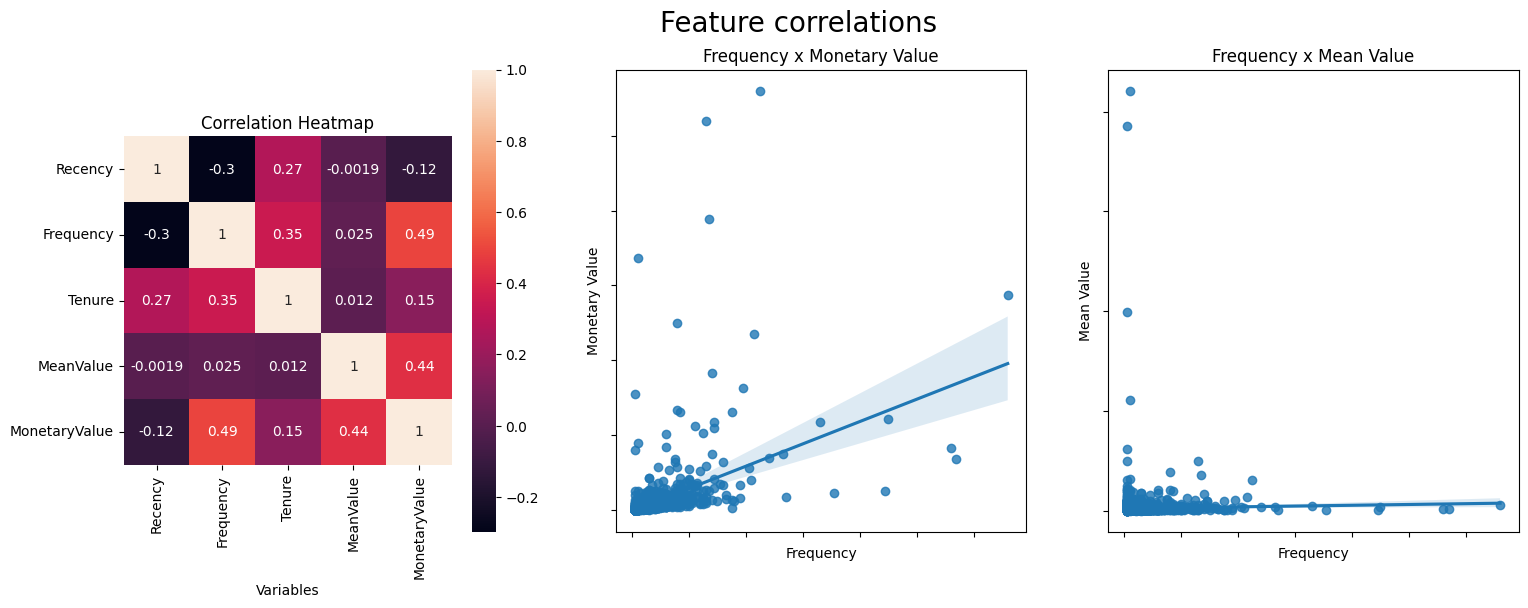

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
# create a heatmap to display the correlations
sns.heatmap(rfm_corr, annot=True, ax=ax[0], square=True)
ax[0].set_ylim([5, 0])
ax[0].set_title('Correlation Heatmap')
ax[0].set_xlabel('Variables')

# plot the regrassion line to highlight the strong correlation
sns.regplot(x='Frequency', y='MonetaryValue', data=rfm_df, ax=ax[1])
ax[1].set_title('Frequency x Monetary Value')
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Monetary Value')
# Turn off tick labels
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

# plot the regrassion line to highlight the strong correlation
sns.regplot(x='Frequency', y='MeanValue', data=rfm_df, ax=ax[2])
ax[2].set_title('Frequency x Mean Value')
ax[2].set_xlabel('Frequency')
ax[2].set_ylabel('Mean Value')
# Turn off tick labels
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

fig.suptitle('Feature correlations', fontsize=20)
plt.show()

### Observations
* As it's clear to see, the __Monetary Value__ and __Frequency__ columns are very strongly correlated (with a coefficient of 0.49). You may think that this is kind of obvious in hindsight: customers who buy more often tend to spend more money in the long run. Although, it goes to show how important it is for you to carefully inspect your data before trying to train any Machine Learning model!

* It's a good practice to drop highly correlated features, as they add some redundancy to your data and may bias the end result of the model. We will drop the __total_value__ and use the __mean_value__ column in our analysis from here on out.

In [22]:
rfm_df.drop('MonetaryValue', axis=1, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_15732\230962175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df.drop('MonetaryValue', axis=1, inplace=True)


### Step Check and Remove Outliers
* Another step we have to take is to remove outliers from the dataset. Since the __K-Means__ algorithm relies on the calculation of the distance between points (most of the time simple euclidean distance), it is heavily influenced by the presence of outliers. Let's start by examining the box plot of our four features.

KeyError: 0

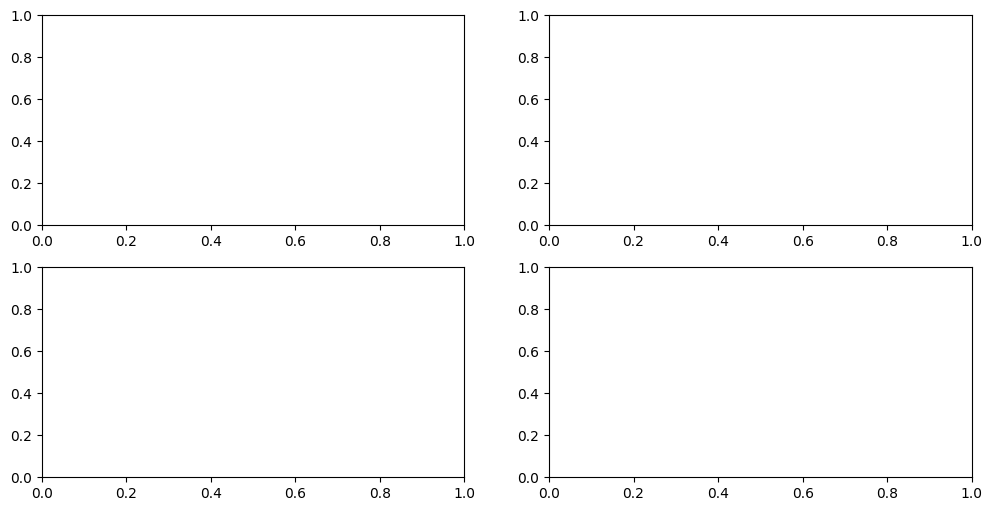

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))

sns.boxplot(rfm_df.Recency, orient='v', ax=ax[0][0])
ax[0][0].set_title('Recency')
ax[0][0].set_ylabel('Values')
ax[0][0].set_yticklabels([])
ax[0][0].set_xticklabels([])

sns.boxplot(rfm_df.Frequency, orient='v', ax=ax[0][1])
ax[0][1].set_title('Frequency')
ax[0][1].set_ylabel('Values')
ax[0][1].set_yticklabels([])
ax[0][1].set_xticklabels([])

sns.boxplot(rfm_df.MeanValue, orient='v', ax=ax[1][0])
ax[1][0].set_title('Monetary')
ax[1][0].set_ylabel('Values')
ax[1][0].set_yticklabels([])
ax[1][0].set_xticklabels([])

sns.boxplot(rfm_df.Tenure, orient='v', ax=ax[1][1])
ax[1][1].set_title('Tenure')
ax[1][1].set_ylabel('Values')
ax[1][1].set_yticklabels([])
ax[1][1].set_xticklabels([])

plt.tight_layout()
plt.show()